In [ ]:
# 📌 Installation des librairies manquantes
!pip install tensorflow matplotlib pandas numpy pillow

# 📌 Importation des librairies
import os
import zipfile
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 📌 URL publique du dataset sur S3
dataset_url = "https://skin-dataset-project.s3.amazonaws.com/oily-dry-and-normal-skin-types-dataset.zip"

# 📥 Téléchargement et extraction automatique avec TensorFlow
dataset_path = tf.keras.utils.get_file(
    fname="oily-dry-and-normal-skin-types-dataset.zip",
    origin=dataset_url,
    extract=True  # On active l'extraction automatique
)

# 📌 Définition du dossier d'extraction basé sur TensorFlow
extract_path = os.path.join(os.path.dirname(dataset_path), "Oily-Dry-Skin-Types")

# 📁 Vérification du contenu après extraction
if os.path.exists(extract_path):
    print(f"✅ Dataset extrait avec succès dans : {extract_path}")
    print(f"📁 Contenu : {os.listdir(extract_path)}")
else:
    print(f"⚠️ Problème : le dossier d'extraction n'existe pas : {extract_path}")

✅ Dataset extrait avec succès dans : /root/.keras/datasets/Oily-Dry-Skin-Types
📁 Contenu : ['train', 'valid', 'README.dataset.txt', 'test']


In [ ]:
# 📌 Récupération du chemin du dataset téléchargé
dataset_zip_path = tf.keras.utils.get_file(
    fname="oily-dry-and-normal-skin-types-dataset.zip",
    origin="https://skin-dataset-project.s3.amazonaws.com/oily-dry-and-normal-skin-types-dataset.zip",
    extract=True  # Extraction automatique
)

# 📌 Correction : On définit le bon dossier d'extraction
dataset_root = os.path.join(os.path.dirname(dataset_zip_path), "Oily-Dry-Skin-Types")

# 📌 Vérification que le dossier existe bien
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"⚠️ Le dossier {dataset_root} n'existe pas. Vérifiez le téléchargement.")

In [ ]:
# 📌 Définition des catégories et des datasets
categories = ["dry", "normal", "oily"]
folders = ["train", "valid", "test"]
datasets = [os.path.join(dataset_root, folder) for folder in folders]

# 📌 Initialisation du dictionnaire des comptes
image_counts = {dataset: {cat: 0 for cat in categories} for dataset in datasets}

# 📌 Parcours des dossiers et comptage des fichiers images
for dataset in datasets:
    dataset_path = os.path.join(dataset_root, dataset)  # 📂 Chemin du dataset (train, valid, test)
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):  # Vérifier que le dossier existe
            image_counts[dataset][category] = len(os.listdir(category_path))  # Compter les fichiers

In [ ]:
# 📌 Conversion en DataFrame avec un index propre
df_counts = pd.DataFrame.from_dict(image_counts, orient="index")
df_counts.index = folders  # On remplace les chemins par 'train', 'valid', 'test'
df_counts.index.name = "Dataset"  # Renommer l'index pour plus de clarté

# 📌 Affichage du tableau propre
print("📊 Distribution des images par dataset et type de peau :")
display(df_counts)

📊 Distribution des images par dataset et type de peau :


,dry,normal,oily
Dataset,,,
train,652,1104,1000
valid,71,111,80
test,35,59,40


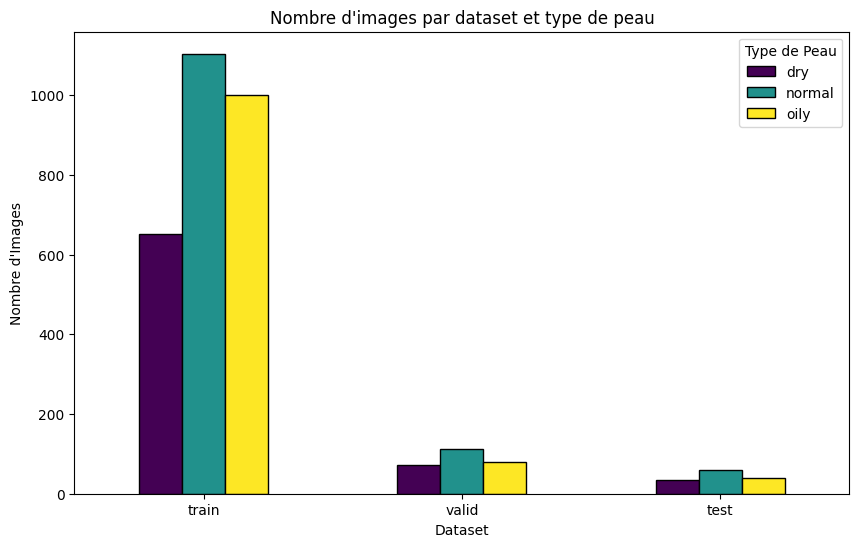

In [ ]:
# 📌 Visualisation de la distribution des images
df_counts.plot(kind="bar", figsize=(10, 6), colormap="viridis", edgecolor="black")
plt.xlabel("Dataset")
plt.ylabel("Nombre d'Images")
plt.title("Nombre d'images par dataset et type de peau")
plt.xticks(rotation=0)
plt.legend(title="Type de Peau")
plt.show()

In [ ]:
# 📌 Fonction pour afficher des images
def show_images(image_list, title, dataset_root, num_cols=5):
    """Affiche une sélection d'images dans un subplot."""
    num_images = len(image_list)
    num_rows = (num_images // num_cols) + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    axes = axes.flatten()

    for i, img_name in enumerate(image_list):
        img_path = os.path.join(dataset_root, img_name)
        if not os.path.exists(img_path):
            print(f"⚠️ Fichier introuvable : {img_path}")
            continue

        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(img_name[:15])

    # Supprimer les cases vides
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

In [ ]:
# 📌 Définition du répertoire contenant les images
train_dir = os.path.join(dataset_root, "train")  # 📂 Dossier contenant les images d'entraînement

# 📌 Sélection de 5 images par catégorie
dry_images = [f"train/dry/{img}" for img in os.listdir(os.path.join(train_dir, "dry"))[:5]]
normal_images = [f"train/normal/{img}" for img in os.listdir(os.path.join(train_dir, "normal"))[:5]]
oily_images = [f"train/oily/{img}" for img in os.listdir(os.path.join(train_dir, "oily"))[:5]]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


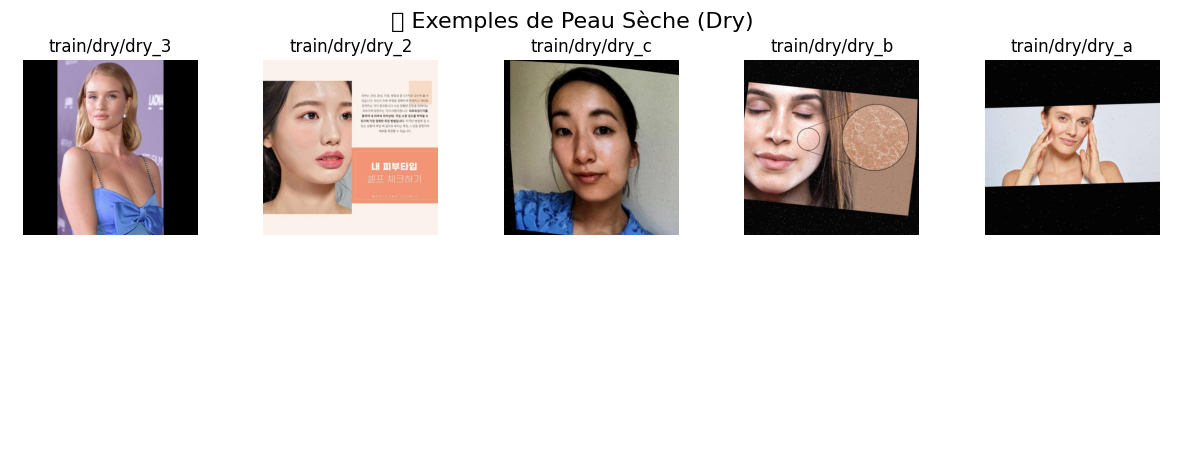

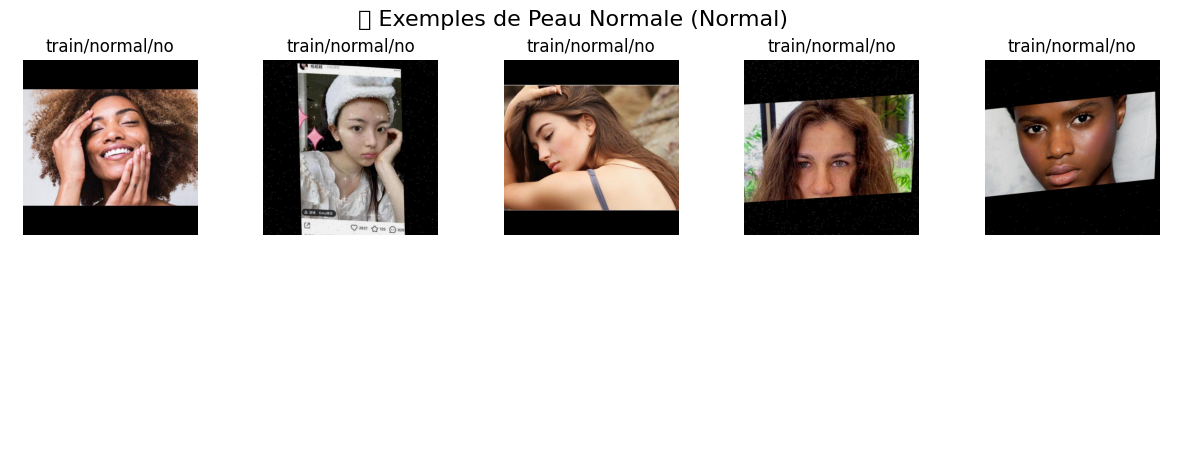

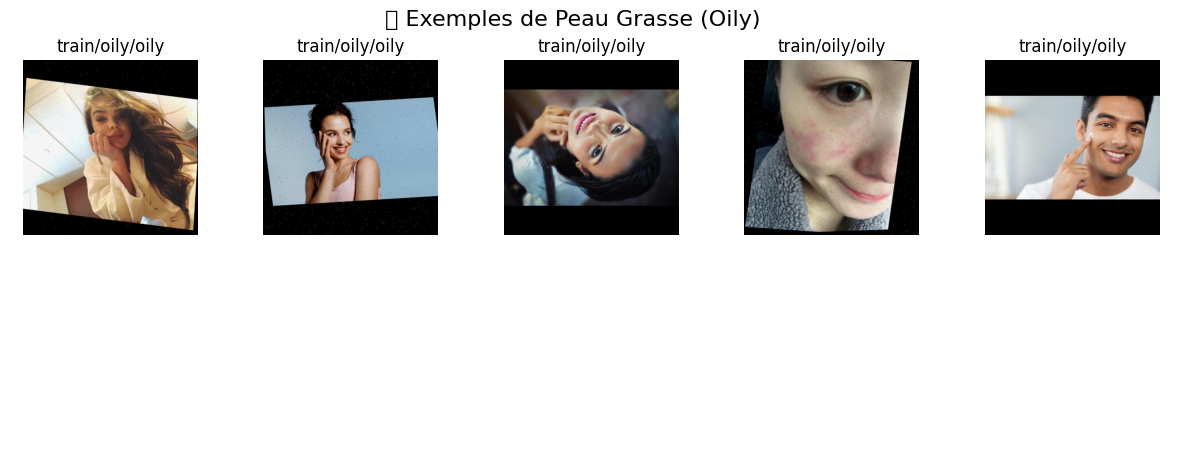

In [ ]:
# 📌 Affichage des images sélectionnées
show_images(dry_images, "📸 Exemples de Peau Sèche (Dry)", dataset_root)
show_images(normal_images, "📸 Exemples de Peau Normale (Normal)", dataset_root)
show_images(oily_images, "📸 Exemples de Peau Grasse (Oily)", dataset_root)

In [ ]:
# Normalisation et Conversion des Labels

# 📌 Définition des paramètres globaux
img_size = (224, 224)  # Taille des images (entrée du modèle)
batch_size = 32  # Taille des lots

# 📌 Normalisation : les valeurs des pixels seront mises entre 0 et 1
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Augmenter la variation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)  # Seulement la normalisation

In [ ]:
# Création d’un générateur d’images avec augmentation (seulement pour le training)
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_root, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_test_datagen.flow_from_directory(
    os.path.join(dataset_root, "valid"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = valid_test_datagen.flow_from_directory(
    os.path.join(dataset_root, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2756 images belonging to 3 classes.
Found 262 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


In [ ]:
# Création des Générateurs de Données pour le Modèle
# 📌 Récupération des indices de classes pour mapping
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# 📌 Affichage des classes détectées
print("📂 Classes détectées :", class_labels)

# 📌 Vérification du nombre d'images par catégorie
print("📊 Nombre d'images par dataset :")
print(f"Train : {train_generator.samples}")
print(f"Validation : {valid_generator.samples}")
print(f"Test : {test_generator.samples}")

📂 Classes détectées : ['dry', 'normal', 'oily']
📊 Nombre d'images par dataset :
Train : 2756
Validation : 262
Test : 134


In [ ]:
# modèle CNN
# 📌 Définition des paramètres du modèle
input_shape = (224, 224, 3)  # Taille des images
num_classes = 3  # Nombre de classes (dry, normal, oily)
learning_rate = 0.001  # Taux d'apprentissage

# 📌 Construction du modèle CNN
model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3,3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Softmax pour classification multiclasse
])


In [ ]:
# 📌 Compilation du modèle
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 📌 Affichage du résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,768,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,161,475 (12.06 MB)

 Trainable params: 3,160,515 (12.06 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# entrainement

# 📌 Définition des paramètres d'entraînement
batch_size = 32
num_epochs = 20  # À ajuster selon les performances
early_stopping = EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True, verbose=1
)

# 📌 Vérification des générateurs de données
print(f"📊 Nombre d'images de train : {train_generator.samples}")
print(f"📊 Nombre d'images de validation : {valid_generator.samples}")

📊 Nombre d'images de train : 2756
📊 Nombre d'images de validation : 262


In [ ]:
# 📌 Entraînement du modèle
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=valid_generator,
    callbacks=[early_stopping],  # Early stopping pour éviter l'overfitting
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 472ms/step - accuracy: 0.3534 - loss: 4.6090 - val_accuracy: 0.4237 - val_loss: 2.9442
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 70s 401ms/step - accuracy: 0.3477 - loss: 2.4649 - val_accuracy: 0.4008 - val_loss: 2.4265
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 37s 399ms/step - accuracy: 0.3971 - loss: 2.1909 - val_accuracy: 0.4237 - val_loss: 1.9958
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - accuracy: 0.3838 - loss: 1.9341 - val_accuracy: 0.4237 - val_loss: 1.7939
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - accuracy: 0.4072 - loss: 1.7411 - val_accuracy: 0.4122 - val_loss: 1.6885
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - accuracy: 0.4202 - loss: 1.5979 - val_accuracy: 0.4237 - val_loss: 1.5003
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 410ms/step - accuracy: 0.3996 - loss: 1.4644 - val_accuracy: 0.4237 - val_loss: 1.4008
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - accuracy: 0.4008 - loss: 1.3847 - val_accuracy: 0.423

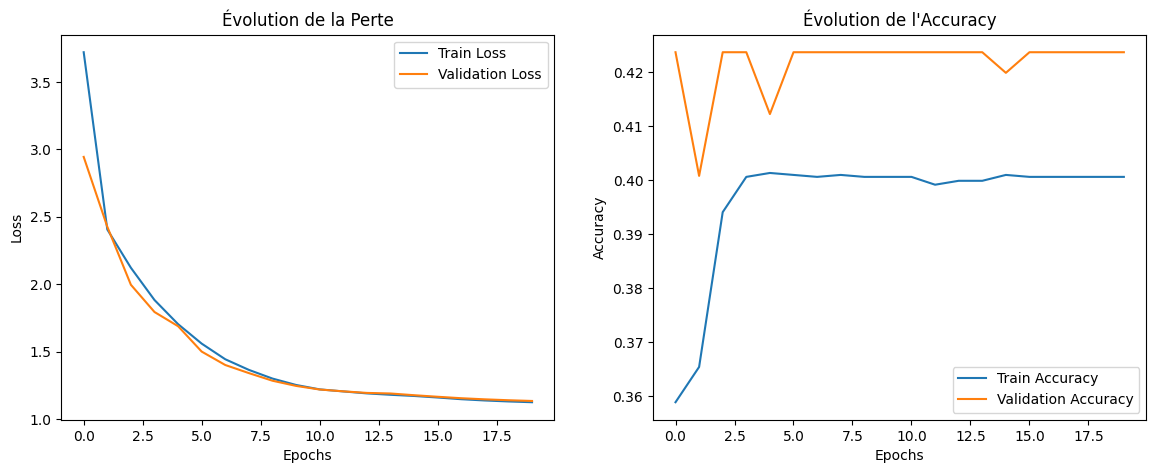

In [ ]:
import matplotlib.pyplot as plt

# 📌 Récupération des métriques
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 📌 Affichage des courbes d'apprentissage
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Courbe de perte
ax[0].plot(train_loss, label="Train Loss")
ax[0].plot(val_loss, label="Validation Loss")
ax[0].set_title("Évolution de la Perte")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Courbe d'accuracy
ax[1].plot(train_acc, label="Train Accuracy")
ax[1].plot(val_acc, label="Validation Accuracy")
ax[1].set_title("Évolution de l'Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()